# 1. Imports and reading data

In [16]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [17]:
ws_prd = pd.read_excel("Data/WS_PRD.xlsx", index_col=0)
ws_prd.dropna(inplace=True)
ws_prd.reset_index(inplace=True, drop=True)
ws_prd["Date"] = pd.to_datetime(ws_prd["Date"])
conduit_sk = ws_prd["UniqueId"].map(lambda Id: Id.split("-A")[0])
ws_prd["Conduit_sk"] = conduit_sk
ws_prd

,Conduit,UniqueId,Date,Days,Oil,Gas,Water,Conduit_sk
0,WS-1012,Sk-0-AS11.2,2009-10-01,11.96,1132.000000,39679.000000,137.000000,Sk-0
1,WS-1012,Sk-0-AS11.2,2009-11-01,30.00,3269.000000,113381.000000,22.000000,Sk-0
2,WS-1012,Sk-0-AS11.2,2009-12-01,30.96,3210.000000,111730.000000,25.000000,Sk-0
3,WS-1012,Sk-0-AS11.2,2010-01-01,31.00,1608.000000,55193.000000,13.000000,Sk-0
4,WS-1012,Sk-0-AS11.2,2010-02-01,28.00,1461.000000,50595.000000,15.000000,Sk-0
...,...,...,...,...,...,...,...,...
120617,WS-7912,Sk-804-AS11.2,2015-05-01,30.42,899.068960,32896.186200,422.034279,Sk-804
120618,WS-7912,Sk-804-AS11.2,2015-06-01,29.86,1084.516308,39681.735080,468.953621,Sk-804
120619,WS-7912,Sk-804-AS11.2,2015-07-01,20.73,610.953093,22354.039750,332.654382,Sk-804
120620,WS-7912,Sk-804-AS11.2,2015-08-01,3.64,424.929566,15547.882720,329.739701,Sk-804


In [18]:
ws_bhp = pd.read_excel("Data/WS_BHP.xlsx", index_col=0)
ws_bhp.dropna(inplace=True)
ws_bhp.reset_index(inplace=True, drop=True)
ws_bhp["Date"] = pd.to_datetime(ws_bhp["Date"])
ws_bhp

,Conduit,Date,BhpEchometerTopPerfDaily
0,Sk-0,2009-10-01,83.852856
1,Sk-0,2009-11-01,67.356537
2,Sk-0,2009-12-01,67.806107
3,Sk-0,2010-01-01,73.733792
4,Sk-0,2010-02-01,74.851226
...,...,...,...
44168,Sk-804,2015-05-01,111.777010
44169,Sk-804,2015-06-01,135.659812
44170,Sk-804,2015-07-01,104.585090
44171,Sk-804,2015-08-01,28.072094


Let's look on the Oil flow rate time series and see how many missing values are there. 

For each well we plot flow rate for all the reservoirs. 

# 2. Viewing data

  0%|          | 0/15 [00:00<?, ?it/s]

Sk-1


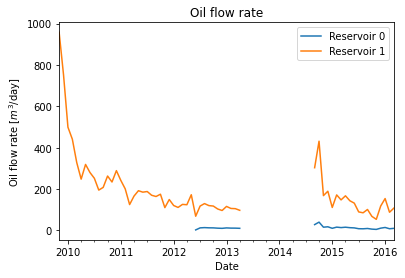

Sk-7


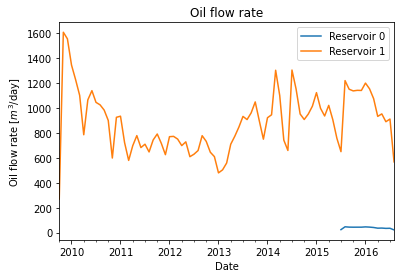

Sk-10


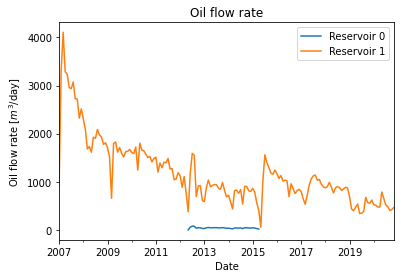

Sk-11


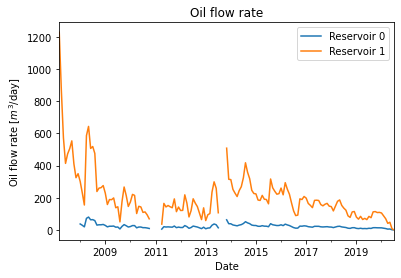

Sk-12


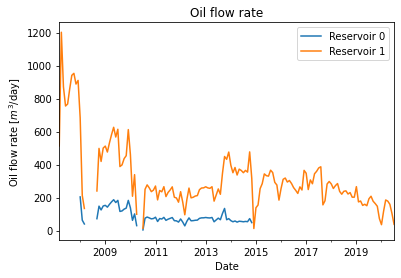

Sk-13


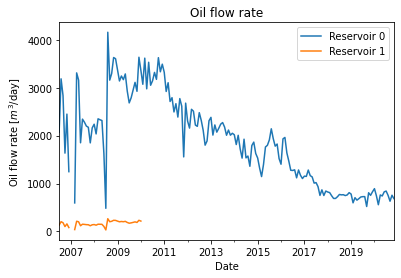

In [19]:
for conduit in tqdm(ws_prd["Conduit_sk"].unique()[:15]):
    ws_prd_sk = ws_prd[ws_prd["Conduit_sk"] == conduit]
    reservs = ws_prd_sk["UniqueId"].unique()
    if len(reservs) > 1:
        for i, reserv in enumerate(reservs):
            reserv_i = ws_prd_sk[ws_prd_sk["UniqueId"] == reserv]
            reserv_i.index = reserv_i["Date"]
            index_full = pd.date_range(start=reserv_i["Date"].iloc[0], end=reserv_i["Date"].iloc[-1], freq='M')
            index_full = index_full.map(lambda dt: dt.replace(day=1))
            reserv_i = reserv_i.reindex(index_full)
            reserv_i["Oil"].plot(label=f"Reservoir {i}")
        print(conduit)
        plt.legend()
        plt.xlabel("Date")
        plt.ylabel("Oil flow rate [$m^3$/day]")
        plt.title("Oil flow rate")
        plt.show()

Now let's look at Bottomhole pressure

  0%|          | 0/15 [00:00<?, ?it/s]

Sk-0


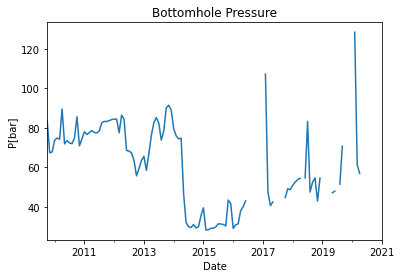

Sk-1


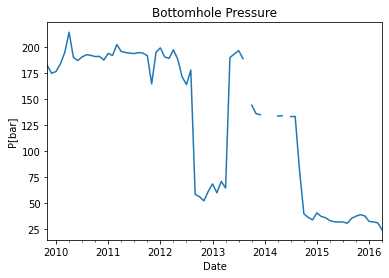

Sk-2


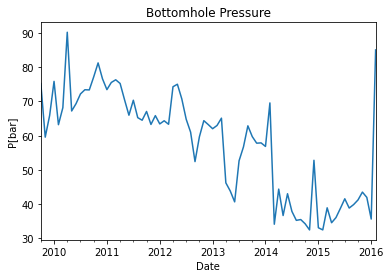

Sk-3


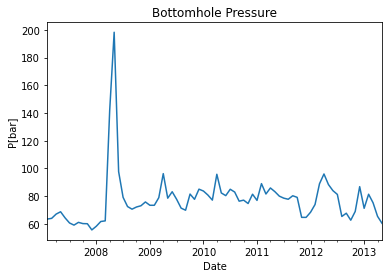

Sk-4


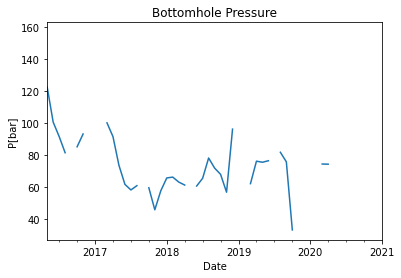

Sk-6


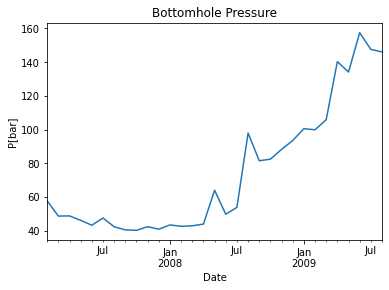

Sk-7


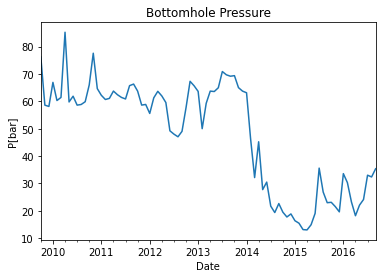

Sk-8


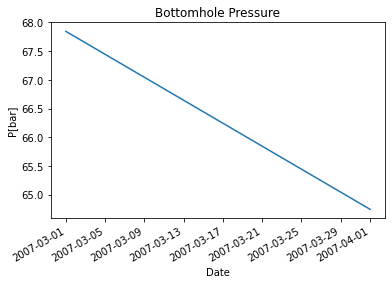

Sk-9


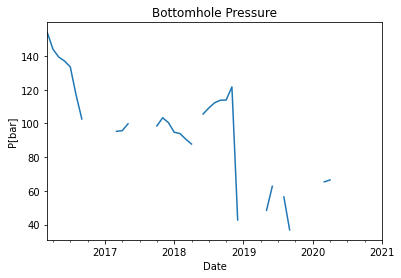

Sk-10


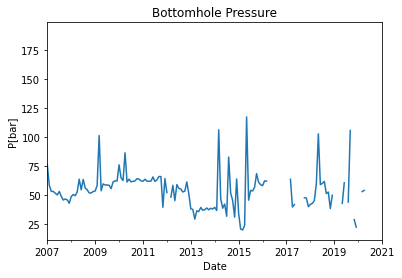

Sk-11


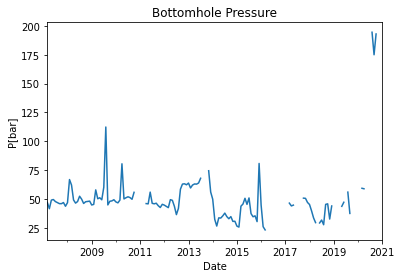

Sk-12


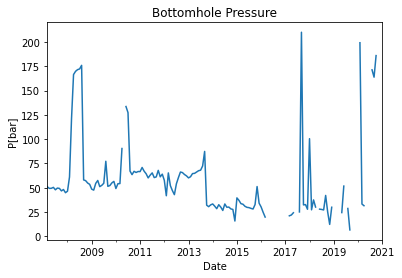

Sk-13


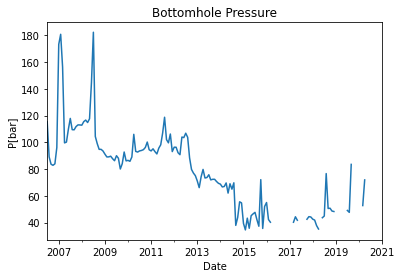

Sk-14


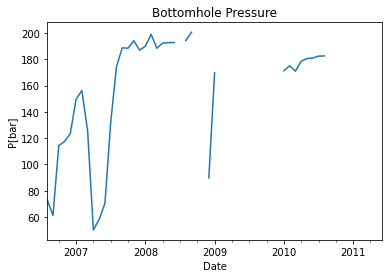

Sk-16


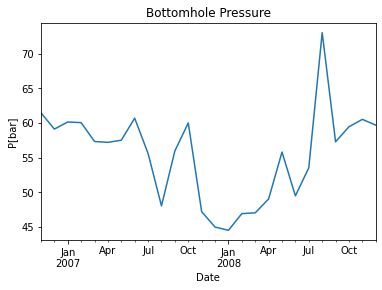

In [20]:
for conduit in tqdm(ws_bhp["Conduit"].unique()[:15]):
    ws_bhp_sk = ws_bhp[ws_bhp["Conduit"] == conduit]
    ws_bhp_sk.index = ws_bhp_sk["Date"]
    index_full = pd.date_range(start=ws_bhp_sk["Date"].iloc[0], end=ws_bhp_sk["Date"].iloc[-1], freq='M')
    index_full = index_full.map(lambda dt: dt.replace(day=1))
    ws_bhp_sk = ws_bhp_sk.reindex(index_full)
    ws_bhp_sk["BhpEchometerTopPerfDaily"].plot()
    print(conduit)
    plt.xlabel("Date")
    plt.ylabel("P[bar]")
    plt.title("Bottomhole Pressure")
    plt
    plt.show()

Flow rate looks very predictable. We'll interpolate it linearly if length of one-by-one sequence is less than a year.

Bhp has a lot of missing points and it is really hard to interpolate them. In order not to drop all the bhp data we'll interpolate them if there are not more than 6 missing points one-by-one. If there are such, the function will split time series by them and further we'll work with splitted parts.

# 3. Summarizing oil flow rates

In [21]:
# Summarize flow rate by all the reservoirs in each well.
# It is taken into account that oil pumping from different reservoirs 
# starts and ends at different time.
debit_sum_list = []
for conduit in tqdm(ws_prd["Conduit_sk"].unique()):
    ws_prd_sk = ws_prd[ws_prd["Conduit_sk"] == conduit]
    delta = (ws_prd_sk["Date"][1:].reset_index() - ws_prd_sk["Date"][:-1].reset_index())["Date"]
    reservoirs = ws_prd_sk["UniqueId"].unique()
    reservoir_sum = ws_prd_sk[ws_prd_sk["UniqueId"] == reservoirs[0]]
    reservoir_sum = reservoir_sum[["Conduit_sk", "Date", "Oil", "Water"]]
    reservoir_sum.index = reservoir_sum["Date"]
    for reserv in reservoirs[1:]:
        reserv_i = ws_prd_sk[ws_prd_sk["UniqueId"] == reserv]
        reserv_i.index = reserv_i["Date"]
        reservoir_sum[["Oil", "Water"]].add(reserv_i[["Oil", "Water"]], fill_value=0)
    debit_sum_list.append(reservoir_sum)

  0%|          | 0/675 [00:00<?, ?it/s]

In [22]:
debit_sum = pd.concat(debit_sum_list, ignore_index=True)
debit_sum.rename(columns={"Conduit_sk": "Conduit"}, inplace=True)
debit_sum

,Conduit,Date,Oil,Water
0,Sk-0,2009-10-01,1132.000000,137.000000
1,Sk-0,2009-11-01,3269.000000,22.000000
2,Sk-0,2009-12-01,3210.000000,25.000000
3,Sk-0,2010-01-01,1608.000000,13.000000
4,Sk-0,2010-02-01,1461.000000,15.000000
...,...,...,...,...
50234,Sk-804,2015-05-01,899.068960,422.034279
50235,Sk-804,2015-06-01,1084.516308,468.953621
50236,Sk-804,2015-07-01,610.953093,332.654382
50237,Sk-804,2015-08-01,424.929566,329.739701


In [23]:
df_merged = pd.merge(debit_sum, ws_bhp, how="outer", on=["Conduit", "Date"])
df_merged.sort_values(by=["Conduit", "Date"])

,Conduit,Date,Oil,Water,BhpEchometerTopPerfDaily
0,Sk-0,2009-10-01,1132.000000,137.000000,83.852856
1,Sk-0,2009-11-01,3269.000000,22.000000,67.356537
2,Sk-0,2009-12-01,3210.000000,25.000000,67.806107
3,Sk-0,2010-01-01,1608.000000,13.000000,73.733792
4,Sk-0,2010-02-01,1461.000000,15.000000,74.851226
...,...,...,...,...,...
6824,Sk-99,2020-09-01,10.842755,99.649324,74.178837
6825,Sk-99,2020-10-01,10.128425,104.647933,NaN
6826,Sk-99,2020-11-01,10.630723,100.797819,NaN
6827,Sk-99,2020-12-01,10.903016,107.294138,NaN


# 4. Interpolate missing values

In [24]:
# Calculates length of longest sequence of missing values
def max_nan_seq(ser):
    max_nan_seq = 0
    nan_seq = 0
    for i, v in enumerate(ser):
        if pd.isna(v):
            nan_seq += 1
            if i == len(ser) - 1:
                max_nan_seq = max(max_nan_seq, nan_seq)
        else:
            max_nan_seq = max(max_nan_seq, nan_seq)
            nan_seq = 0
    return max_nan_seq

# Splits pd.Series by sequences with >=k nans
def split_seq_nans(ser, k):
    split_ser_list = []
    split_ser = []
    split_ser_indices = []
    nan_seq = 0
    for i, v in enumerate(ser):
        if pd.isna(v):
            nan_seq += 1
            if nan_seq >= k:
                if len(split_ser) > 0:
                    split_ser_list.append(pd.Series(split_ser, index=split_ser_indices))
                    split_ser = []
                    split_ser_indices = []
        else:
            if nan_seq >= k:
                split_ser_list.append(pd.Series(None, index=range(i - nan_seq, i)))
            nan_seq = 0
        split_ser.append(v)
        split_ser_indices.append(ser.index[i])
    if nan_seq >= k:
        split_ser_list.append(pd.Series(None, index=range(i + 1 - nan_seq, i + 1)))
    if len(split_ser) > 0:
        split_ser_list.append(pd.Series(split_ser, index=split_ser_indices))

    drop_list = []    
    for i, s in enumerate(split_ser_list):
    #     print(s)
    #     print(s.last_valid_index())
        if s.last_valid_index() is None:
            drop_list.append(i)
        else:
            split_ser_list[i] = s[s.first_valid_index():s.last_valid_index()]
    split_ser_list = [split_ser_list[i] for i in range(len(split_ser_list)) if i not in drop_list]
    return split_ser_list

In [26]:
history_len = 24
forecast_len = 6
data_len = history_len + forecast_len

samples_list = []
for conduit in tqdm(ws_prd["Conduit_sk"].unique()):
    if conduit == "Sk-173-SEN":
        continue
    ws_prd_sk = ws_prd[ws_prd["Conduit_sk"] == conduit]
    reservs = ws_prd_sk["UniqueId"].unique()
    reservs_interp = []
    for reserv in reservs:
        reserv_i = ws_prd_sk[ws_prd_sk["UniqueId"] == reserv]
        reserv_i.index = reserv_i["Date"]
        index_full = pd.date_range(start=reserv_i["Date"].iloc[0], end=reserv_i["Date"].iloc[-1], freq='M')
        index_full = index_full.map(lambda dt: dt.replace(day=1))
        reserv_i = reserv_i.reindex(index_full)

        reserv_i["Oil"] = reserv_i["Oil"].interpolate()
        reserv_i["Water"] = reserv_i["Water"].interpolate()
        reservs_interp.append(reserv_i)

    reservoir_sum = reservs_interp[0].copy()
    for reserv in reservs_interp[1:]:
        reservoir_sum = reservoir_sum[["Oil", "Water"]].add(reserv[["Oil", "Water"]], fill_value=0)


    ws_bhp_sk = ws_bhp[ws_bhp["Conduit"] == conduit]
    ws_bhp_sk.index = ws_bhp_sk["Date"]
    index_full = pd.date_range(start=ws_bhp_sk["Date"].iloc[0], end=ws_bhp_sk["Date"].iloc[-1], freq='M')
    index_full = index_full.map(lambda dt: dt.replace(day=1))
    ws_bhp_sk = ws_bhp_sk.reindex(index_full)
    
    k = 6 # number of nans in a sequence to split
    series_list = split_seq_nans(ws_bhp_sk["BhpEchometerTopPerfDaily"], k)
    samp_num = 0
    for bhp in series_list:
        bhp = bhp.interpolate()
        if len(bhp) >= data_len:
            index = bhp.index.intersection(reservoir_sum.index)
            interpolated_sample = reservoir_sum[["Oil", "Water"]].loc[index]
            interpolated_sample["Bhp"] = bhp[index]
            interpolated_sample["Conduit"] = conduit
            interpolated_sample["Id"] = conduit + '_' + str(samp_num)
            if len(interpolated_sample) >= data_len:
                samples_list.append(interpolated_sample)
                samp_num += 1
#             interpolated_sample[["Oil", "Water"]].plot()
#             plt.show()
#             bhp.plot()
#             plt.show()
#             interpolated_sample["Bhp"].plot()
#             plt.show()

  0%|          | 0/675 [00:00<?, ?it/s]

In [27]:
concat = pd.concat(samples_list)
concat = concat.reset_index(drop=False)
concat = concat.rename(columns={"index": "Date"})
concat

,Date,Oil,Water,Bhp,Conduit,Id
0,2009-10-01,1132.000000,137.000000,83.852856,Sk-0,Sk-0_0
1,2009-11-01,3269.000000,22.000000,67.356537,Sk-0,Sk-0_0
2,2009-12-01,3210.000000,25.000000,67.806107,Sk-0,Sk-0_0
3,2010-01-01,1608.000000,13.000000,73.733792,Sk-0,Sk-0_0
4,2010-02-01,1461.000000,15.000000,74.851226,Sk-0,Sk-0_0
...,...,...,...,...,...,...
46239,2020-05-01,788.246777,603.611564,62.661947,Sk-802,Sk-802_0
46240,2020-06-01,808.666082,628.149909,67.812732,Sk-802,Sk-802_0
46241,2020-07-01,721.501283,544.290447,72.963517,Sk-802,Sk-802_0
46242,2020-08-01,645.424997,486.899550,78.114302,Sk-802,Sk-802_0


# 5. Save data for training LSTM

In [28]:
history_len = 24
forecast_len = 6
data_len = history_len + forecast_len
stride = 6
history_list, forecast_list = [], []
features = ["Oil", "Water", "Bhp"]
lstm_data_list, conduits = [], []
for Id in tqdm(concat["Id"].unique()):
    df_conduit = concat[concat["Id"] == Id]
    df_conduit = df_conduit.set_index("Date")
    for begin in range(0, len(df_conduit) - data_len + 1, stride):
        lstm_data_list.append(df_conduit[begin: begin + data_len][features])
        conduits.append(df_conduit["Conduit"].unique()[0])

  0%|          | 0/804 [00:00<?, ?it/s]

# 6. Save files

In [29]:
concat.to_csv("Data/Interpolated_ts_splitnans_6.csv")

In [30]:
lstm_data = np.array(lstm_data_list)
np.save("Data/lstm_data.npy", lstm_data)

In [31]:
oil = pd.DataFrame(lstm_data[:, :, 0])
oil["Conduit"] = conduits
oil.to_csv("Data/Oil.csv")
water = pd.DataFrame(lstm_data[:, :, 1])
water["Conduit"] = conduits
water.to_csv("Data/Water.csv")
bhp = pd.DataFrame(lstm_data[:, :, 2])
bhp["Conduit"] = conduits
bhp.to_csv("Data/bhp.csv")